In [1]:
import sys
sys.path.append('/home/gperri-ext/master_thesis_tryout-2/')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_v2_behavior() # for shap

import keras_tuner as kt
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, ConvLSTM1D, TimeDistributed, Flatten, Dropout, RepeatVector, Activation, ReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


from models.evaluation_func import single_timeseries_evaluation_metrics_func, evaluate_and_plot_timeseries, NMAE_error
from models.visualization import plot_model_loss, plot_error_metrics_barchart, plot_model_rmse_and_loss
from models.windowing_data import multivariate_data, prepare_data
from models.temp_features import make_yearly_dataset, create_cyclic_features, transform_time_features
from models.daily_errors import 


from tensorflow import keras, config
from keras import layers

physical_devices = config.list_physical_devices('GPU') 
try:
    config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

%matplotlib inline


2024-02-20 07:39:55.025666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


### Importing data

In [2]:
data_folder = "/home/gperri-ext/master_thesis_tryout-2/data"
file_name = "all_data.csv"

try:
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    
except FileNotFoundError:
    print("File not found. Please provide the correct path to the data folder.")

In [3]:
df.set_index('Time_data', inplace=True)
df.index = pd.to_datetime(df.index)

In [4]:
# Separate features inputs
df_PUN = df.iloc[:, :3]
df_GAS = df.iloc[:, :5]
df_total_load = df.iloc[:, :7]
df_PUN7 = df.iloc[:,:2]
df_no_tlf = df[['PUN','PUN_d+1-7','GAS', 'GAS_d+1-7','Total_Load_d+1-7', 'Ora', 'holiday']]

### Preparing I/O

In [ ]:
# df.columns
# df_temp = df[['PUN','PUN_d+1-7','GAS','GiornoSettimana', 'Ora', 'holiday']]

In [52]:
# Choose dataset input
dataset_input = make_yearly_dataset(df, 2018, 2020)
print(dataset_input.tail(5))

                             PUN  PUN_d+1-7  PUN_d+1-14    GAS  GAS_d+1-7   
Time_data                                                                   
2020-12-31 19:00:00+00:00  63.74      51.54       74.39  17.54      16.14  \
2020-12-31 20:00:00+00:00  60.21      49.15       65.74  17.54      16.14   
2020-12-31 21:00:00+00:00  53.69      49.68       59.54  17.54      16.14   
2020-12-31 22:00:00+00:00  53.82      49.67       56.43  17.54      16.14   
2020-12-31 23:00:00+00:00  54.19      44.92       51.97  17.54      16.14   

                           Total_load_f  Total_Load_d+1-7  GiornoSettimana   
Time_data                                                                    
2020-12-31 19:00:00+00:00       34538.0          32756.08                3  \
2020-12-31 20:00:00+00:00       33924.0          30389.21                3   
2020-12-31 21:00:00+00:00       32055.0          27925.11                3   
2020-12-31 22:00:00+00:00       29550.0          25598.64             

In [53]:
target_size = 24
past_history = 24
train_size = 0.7
test_size = 0.3

train_index = int(len(dataset_input) * train_size)
test_index = train_index + int(len(dataset_input) * test_size)

In [54]:
univariate = False

X, y = prepare_data(dataset_input, univariate=univariate)

In [55]:
# Utilizza due scaler diversi per evitare bias
X_sc = MinMaxScaler()
y_sc = MinMaxScaler()

X_sc.fit(X[:train_index])
y_sc.fit(y[:train_index])

X_norm = X_sc.transform(X)
y_norm = y_sc.transform(y)


y_norm = y_norm.squeeze()


In [56]:
step = 1

# Prepara i dati utilizzando la funzione multivariate_data
X_train, y_train = multivariate_data(X_norm, y_norm,
                                        0, train_index, past_history,
                                        target_size, step=step, single_step=False)

X_test, y_test = multivariate_data(X_norm, y_norm,
                                    train_index, test_index, past_history,
                                    target_size, step=step, single_step=False)

# Stampa le dimensioni dei dati
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (17791, 24, 10)
y_train shape: (17791, 24)
X_test shape: (7555, 24, 10)
y_test shape: (7555, 24)


In [57]:
y_test_inv = y_sc.inverse_transform(y_test)
input_shape = X_train.shape[-2:]


#### Single Trial

In [58]:
tf.keras.backend.clear_session()

# Crea il modello LSTM
model = tf.keras.Sequential()
# return_sequences: Boolean. Whether to return the last output in the output sequence, 
# or the full sequence. Default: False.
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(150))
# model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1]))  # Output layer ha un neurone per ogni ora da prevedere


In [59]:
# Definisci il callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0002, restore_best_weights=True)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=40,
                                batch_size=64, validation_split=0.2, 
                                callbacks = [early_stopping])

# A batch of data is a fixed-sized number of rows from the training dataset that defines
# how many patterns to process before updating the weights of the network

Train on 14232 samples, validate on 3559 samples
Epoch 1/40


2024-02-20 08:27:21.761639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11539 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-02-20 08:27:21.840494: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/learning_rate/Assign' id:609 op device:{requested: '', assigned: ''} def:{{{node training/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/learning_rate, training/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


14208/14232 [============================>.] - ETA: 0s - loss: 0.0125

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-02-20 08:27:30.445688: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:218 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


14232/14232 [==============================] - 10s 676us/sample - loss: 0.0125 - val_loss: 0.0040
Epoch 2/40
14232/14232 [==============================] - 9s 666us/sample - loss: 0.0054 - val_loss: 0.0033
Epoch 3/40
14232/14232 [==============================] - 9s 662us/sample - loss: 0.0045 - val_loss: 0.0031
Epoch 4/40
14232/14232 [==============================] - 9s 656us/sample - loss: 0.0036 - val_loss: 0.0021
Epoch 5/40
14232/14232 [==============================] - 9s 649us/sample - loss: 0.0029 - val_loss: 0.0019
Epoch 6/40
14232/14232 [==============================] - 9s 624us/sample - loss: 0.0027 - val_loss: 0.0018
Epoch 7/40
14232/14232 [==============================] - 9s 624us/sample - loss: 0.0025 - val_loss: 0.0017
Epoch 8/40
14232/14232 [==============================] - 9s 601us/sample - loss: 0.0024 - val_loss: 0.0016
Epoch 9/40
14232/14232 [==============================] - 9s 645us/sample - loss: 0.0023 - val_loss: 0.0016
Epoch 10/40
14232/14232 [=============

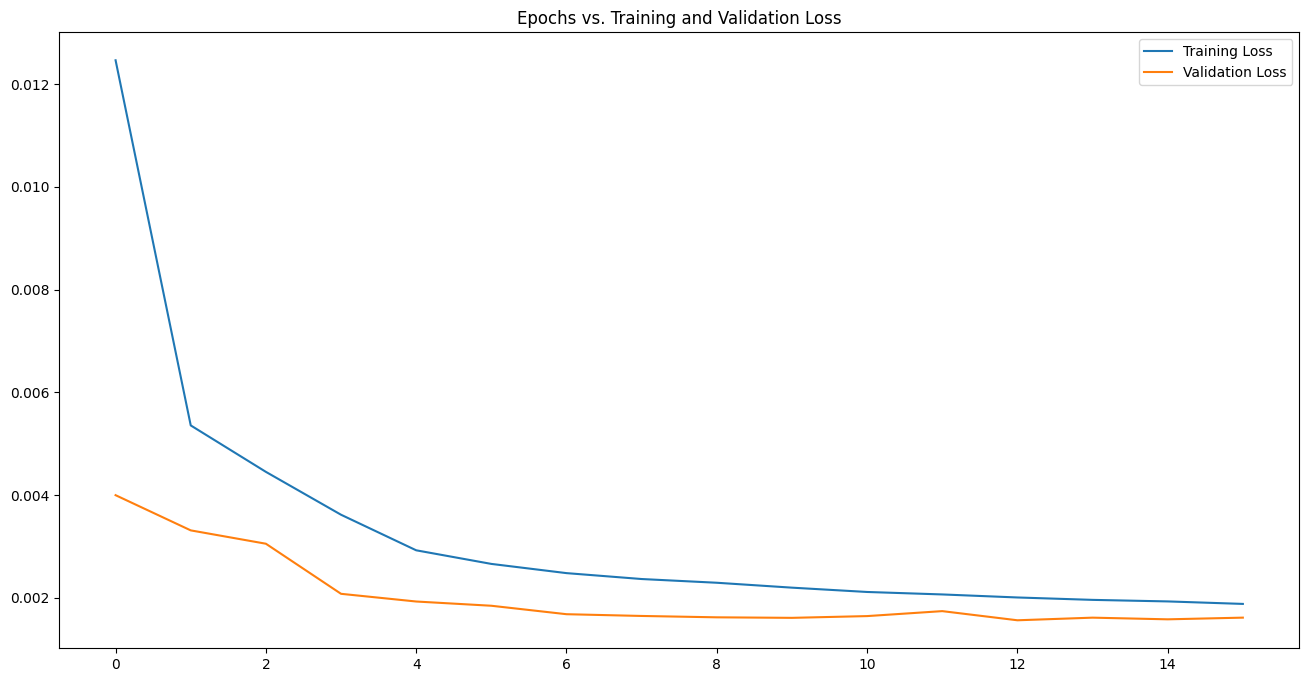

In [60]:
plot_model_loss(history)

In [61]:
# Valuta il modello
loss = model.evaluate(X_test, y_test)
print(f'Errore quadratico medio: {loss}')

# Fai previsioni per il test set
forecast = model.predict(X_test)

# Denormalizza le previsioni
lstm_forecast = y_sc.inverse_transform(forecast)



Errore quadratico medio: 0.001933439334279418


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-02-20 08:29:50.500243: W tensorflow/c/c_api.cc:304] Operation '{name:'dense/BiasAdd' id:200 op device:{requested: '', assigned: ''} def:{{{node dense/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense/MatMul, dense/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [62]:
y_test_inv = y_sc.inverse_transform(y_test)

In [63]:
# if univariate:
#     y_test_inv = y_sc.inverse_transform(y_test.squeeze(-1))
# else: 
#     y_test_inv = y_sc.inverse_transform(y_test)

In [64]:
# forflat = uni_lstm_forecast.flatten()

#### Error on rows instead of columns 

In [65]:
def evaluate_timeseries_forecast(y_test_inv, forecast):
    """
    Evaluate time series forecasts by comparing row-wise and calculate the mean error.

    Args:
        y_test_inv (array-like): Array of actual data.
        forecast (array-like): Array of forecasts.

    Returns:
        float: Mean error calculated over all rows.
    """
    # Initialize a list to store the error for each row
    errors = []

    # Loop through the rows
    for row_idx in range(y_test_inv.shape[0]):
        # Select the actual and forecasted values for the current row
        y_true_row = y_test_inv[row_idx, :]
        y_pred_row = forecast[row_idx, :]

        # Calculate the error for this row
        error_row = NMAE_error(y_true_row, y_pred_row)

        # Append the error to the list
        errors.append(error_row)

    # Calculate the mean error over all rows
    mean_error = np.mean(errors)

    return mean_error

# def evaluate_timeseries_forecast(y_test_inv, forecast):
#     """
#     Evaluate time series forecasts by comparing row-wise and calculate the mean error, RMSE, MAPE, and NMAE.

#     Args:
#         y_test_inv (array-like): Array of actual data.
#         forecast (array-like): Array of forecasts.

#     Returns:
#         tuple: Tuple containing mean error, RMSE, MAPE, and NMAE.
#     """
#     # Initialize lists to store errors for each row
#     errors = []
#     rmse_list = []
#     mape_list = []
#     nmae_list = []

#     # Loop through the rows
#     for row_idx in range(y_test_inv.shape[0]):
#         # Select the actual and forecasted values for the current row
#         y_true_row = y_test_inv[row_idx, :]
#         y_pred_row = forecast[row_idx, :]

#         # Calculate the errors for this row
#         error_row = calculate_error(y_true_row, y_pred_row)
#         rmse_row = np.sqrt(metrics.mean_squared_error(y_true_row, y_pred_row))
#         mape_row = mean_absolute_percentage_error(y_true_row, y_pred_row)
#         nmae_row = NMAE_error(y_true_row, y_pred_row)

#         # Append the errors to the lists
#         errors.append(error_row)
#         rmse_list.append(rmse_row)
#         mape_list.append(mape_row)
#         nmae_list.append(nmae_row)

#     # Calculate the mean errors
#     mean_error = np.mean(errors)
#     mean_rmse = np.mean(rmse_list)
#     mean_mape = np.mean(mape_list)
#     mean_nmae = np.mean(nmae_list)

#     return mean_error, mean_rmse, mean_mape, mean_nmae


In [66]:
def calculate_error(y_true, y_pred):
    """
    Calculate the error between a set of actual values and a set of predicted values.

    Args:
        y_true (array-like): Array of actual values.
        y_pred (array-like): Array of predicted values.

    Returns:
        float: Calculated error.
    """
    # Calculate the absolute error between the actual and predicted values for each element
    errors = np.abs(y_true - y_pred)

    # Calculate the mean error
    mean_error = np.mean(errors)

    return mean_error


In [67]:
evaluate_timeseries_forecast(y_test_inv, lstm_forecast)

0.15183656796535164

In [68]:
def visualize_errors(errors):
    """
    Visualize errors calculated for each row.

    Args:
        errors (array-like): Array of errors calculated for each row.

    Returns:
        None
    """
    # Create an array of row indices
    row_indices = range(1, len(errors) + 1)

    # Plot the errors
    plt.figure(figsize=(10, 6))
    plt.bar(row_indices, errors, color='skyblue')
    plt.xlabel('Row')
    plt.ylabel('Error')
    plt.title('Errors for Each Row')
    plt.grid(True)
    plt.show()

In [69]:
errors = []

for row_idx in range(y_test_inv.shape[0]):
    y_true_row = y_test_inv[row_idx, :]
    y_pred_row = lstm_forecast[row_idx, :]
    error_row = calculate_error(y_true_row, y_pred_row)
    errors.append(error_row)


In [70]:
# Ottieni il timestamp per le righe di test
test_timestamps = dataset_input.iloc[-y_test_inv.shape[0]:].index

# Converti l'indice in oggetti datetime
test_timestamps = pd.to_datetime(test_timestamps)

In [71]:
def visualize_errors_with_timestamps(errors, timestamps):
    """
    Visualizza gli errori calcolati per ogni riga con i relativi timestamp utilizzando un grafico a barre.

    Args:
        errors (array-like): Array degli errori calcolati per ogni riga.
        timestamps (array-like): Array dei timestamp corrispondenti.

    Returns:
        None
    """
    # Plot degli errori con i timestamp utilizzando un grafico a barre
    plt.figure(figsize=(12, 6))
    plt.bar(timestamps, errors, width=0.8, color='skyblue')
    plt.xlabel('Timestamp')
    plt.ylabel('Error')
    plt.title('Errors Over Time')
    plt.xticks(rotation=45)  # Ruota le etichette sull'asse x per una migliore leggibilità
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Linee orizzontali tratteggiate
    plt.tight_layout()
    plt.show()


314


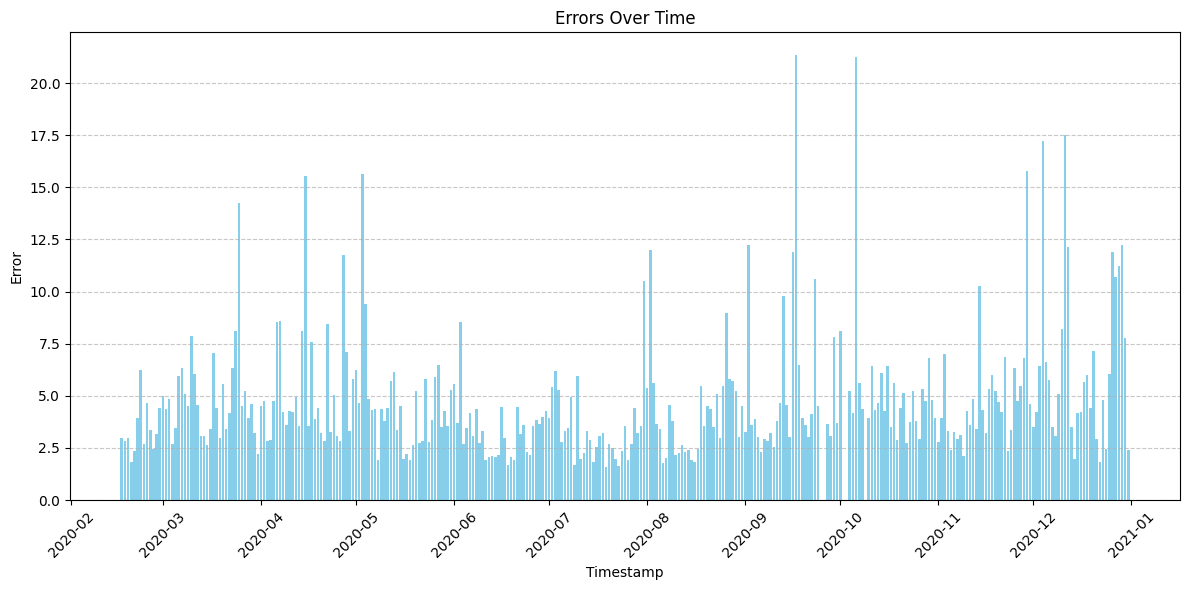

Media degli errori relativi alla mezzanotte: 4.755729498397519


In [72]:
def filter_errors_at_midnight(errors, timestamps):
    '''Function used to filter only forecasts starting at 00.00'''
    midnight_errors = []
    midnight_timestamps = []
    count = 0
    for error, timestamp in zip(errors, timestamps):
        hour = timestamp.hour

        if hour == 0:
            midnight_errors.append(error)
            midnight_timestamps.append(timestamp)
            count += 1
    print(count)        
    return midnight_errors, midnight_timestamps

midnight_errors, midnight_timestamps = filter_errors_at_midnight(errors, test_timestamps)

visualize_errors_with_timestamps(midnight_errors, midnight_timestamps)

mean_midnight_error = np.mean(midnight_errors)

print("Media degli errori relativi alla mezzanotte:", mean_midnight_error)

#### Errors on columns

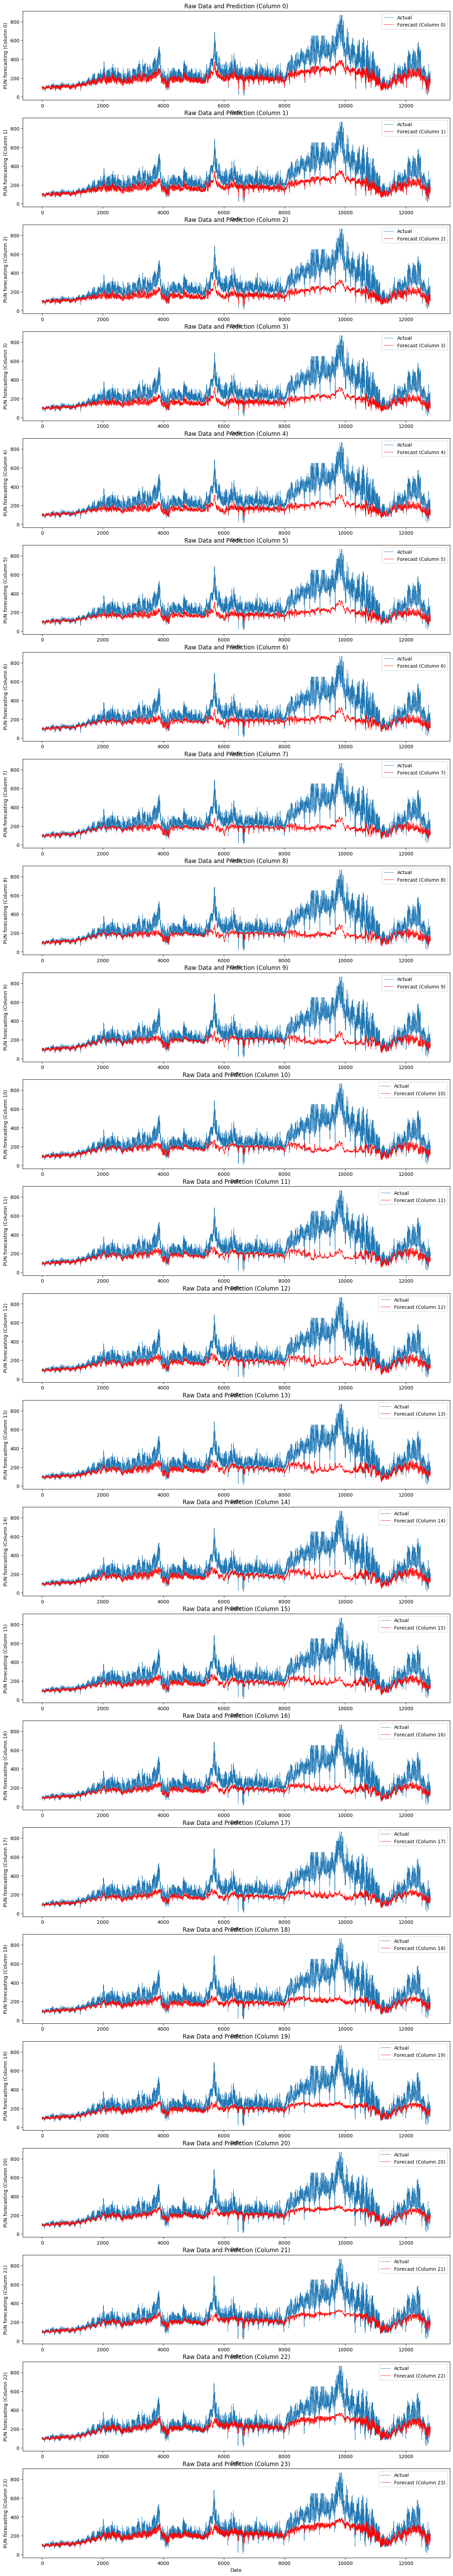

In [30]:
uni_table = evaluate_and_plot_timeseries(y_test_inv, lstm_forecast, show_plot=True)

Min NMAE: 0.219 for Column: 22.0
Min RMSE: 94.235 for Column: 22.0
Min MAPE: 17.786 for Column: 22.0
Mean NMAE: 0.339875
Mean RMSE: 134.96629166666665
Mean MAPE: 27.341208333333338


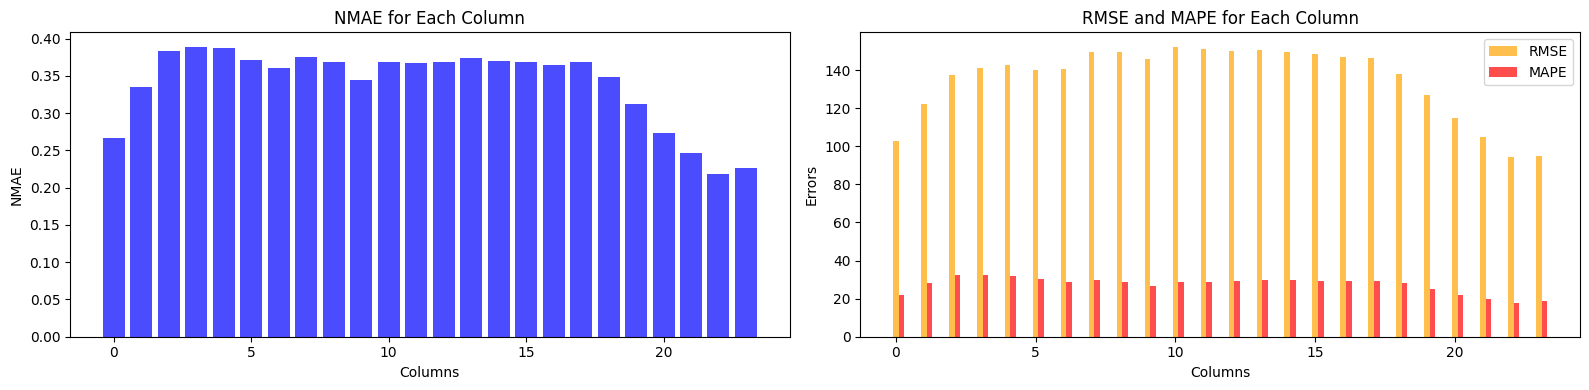

In [29]:
plot_error_metrics_barchart(uni_table)

##### Prova SHAP

In [ ]:
'''Ideas taken from https://www.kaggle.com/code/ltsmssv/shap-for-lstm-hpccv2/notebook'''

In [244]:
# import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [245]:
tf.__version__

'2.13.0-rc0'

In [240]:
# !pip install shap
import shap

In [243]:
shap.__version__

'0.44.1'

In [263]:
X_test.shape

(12617, 24, 10)

In [266]:
# Crea un esplainer SHAP
explainer = shap.DeepExplainer(model, X_train[:1000])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [267]:
shap_values = explainer.shap_values(X_test[:50])

In [268]:
shap.initjs()

In [273]:
for i in range(len(shap_values)):
    shap.force_plot(explainer.expected_value[0], shap_values[i][0], X_test[i])


In [272]:
# Visualizza gli SHAP values
shap.summary_plot(shap_values, X_test[0])

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [224]:
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_train[:10])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


TypeError: Tensors are unhashable (this tensor: KerasTensor(type_spec=TensorSpec(shape=(?, 24, 10), dtype=tf.float32, name='lstm_input'), name='lstm_input', description="created by layer 'lstm_input'")). Instead, use tensor.ref() as the key.

In [219]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.44.1
Tensorflow version is: 2.13.0-rc0


In [220]:
# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10].values)

NameError: name 'explainer' is not defined

### Multivariate

In [246]:
tf.keras.backend.clear_session()
multivariate_lstm = tf.keras.Sequential()

# multivariate_lstm.add(LSTM(200, input_shape=input_shape, return_sequences=True)) 
# multivariate_lstm.add(Dropout(0.2))

multivariate_lstm.add(LSTM(100, input_shape=input_shape)) 
multivariate_lstm.add(Dropout(0.2))


# multivariate_lstm.add(Activation(custom_activation,name = "Swish"))
# multivariate_lstm.add(Dense(100))
multivariate_lstm.add(Dense(target_size))



multivariate_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
Total params: 46824 (182.91 KB)
Trainable params: 46824 (182.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [247]:
# Callback per il salvataggio del modello
# lstm_checkpoint = ModelCheckpoint('multivariate_lstm_df_gas.h5', monitor='val_loss', save_best_only=True)

multivariate_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
# multivariate_lstm.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(1e-8, momentum=0.9) , metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

# Vuole questa metrica altrimenti fa capricci con la stringa
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]), 1)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-5 * 10**(epoch/20))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

Train on 23680 samples, validate on 5921 samples
Epoch 1/50


2024-02-12 14:22:37.496603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11539 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-02-12 14:22:37.517417: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-02-12 14:22:37.581797: W tensorflow/c/c_api.cc:304] Operation '{name:'training/Adam/learning_rate/Assign' id:633 op device:{requested: '', assigned: ''} def:{{{node training/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/learning_rate, training/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


23616/23680 [============================>.] - ETA: 0s - loss: 0.0174 - root_mean_squared_error: 0.1319

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-02-12 14:22:51.415434: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:242 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


23680/23680 [==============================] - 15s 633us/sample - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.1014 - val_root_mean_squared_error: 0.3185 - lr: 1.0000e-05
Epoch 2/50
23680/23680 [==============================] - 14s 600us/sample - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2604 - lr: 1.1220e-05
Epoch 3/50
23680/23680 [==============================] - 14s 591us/sample - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2271 - lr: 1.2589e-05
Epoch 4/50
23680/23680 [==============================] - 14s 589us/sample - loss: 0.0033 - root_mean_squared_error: 0.0574 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1961 - lr: 1.4125e-05
Epoch 5/50
23680/23680 [==============================] - 14s 589us/sample - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1521 - lr: 1.5849e-05
Epoch 6/50
23680/2368

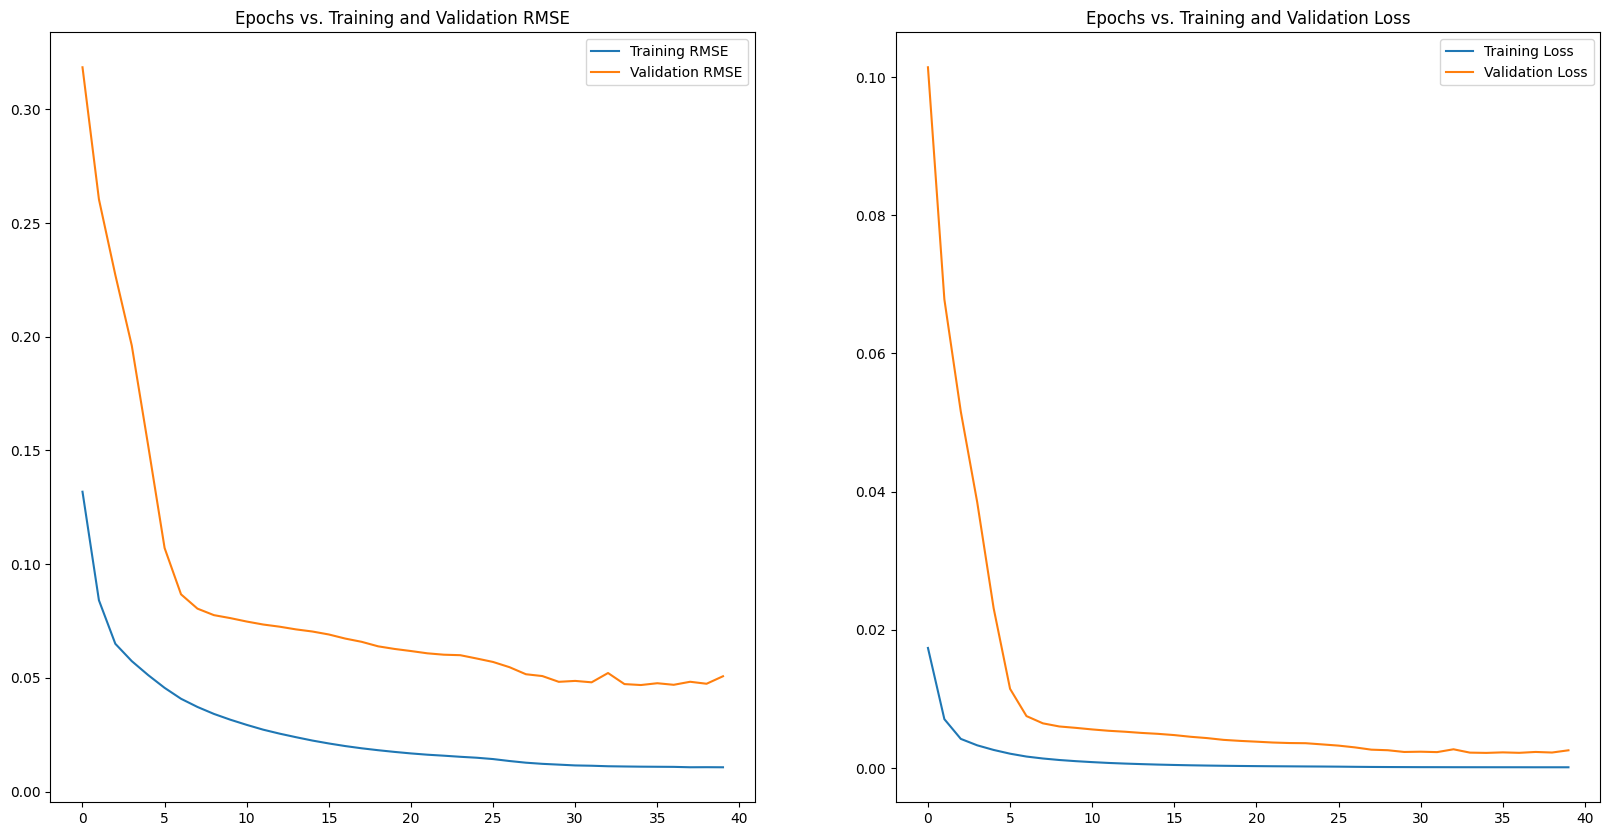

In [248]:

history = multivariate_lstm.fit(X_train, y_train, epochs=50, verbose=1,
                                validation_split=0.2, batch_size=64,
                                callbacks=[early_stopping, lr_schedule])

plot_model_rmse_and_loss(history)


In [ ]:
# multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = y_sc.inverse_transform(forecast)


In [ ]:
lstm_table = evaluate_and_plot_timeseries(y_test_inv, lstm_forecast, show_plot=True)

In [ ]:
plot_error_metrics_barchart(lstm_table)


### Hyperparameters search

In [ ]:
# Define the model function
def build_model(hp):
  model = tf.keras.Sequential()
  # Choose the number of LSTM layers between 1 and 3
  for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
    # Choose the number of LSTM units between 50 and 200
    # Check the value of num_layers to set return_sequences
    if hp.get('num_layers') == 1:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    else:
      model.add(LSTM(hp.Int('units_' + str(i), min_value=50, max_value=200, step=50), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    # Choose the dropout between 0 and 0.5
    model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0, max_value=0.5, step=0.1)))
  # Add the output layer with one neuron for each hour to predict
  model.add(Dense(y_train.shape[1]))
  # Compile the model using adam as optimizer and mean_squared_error as loss function
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0002, restore_best_weights=True)

tuner = kt.BayesianOptimization(build_model, objective='val_loss', max_trials=10, 
                                num_initial_points=2, beta=2.6, project_name='LSTM_tuning_multivariate')

tuner.search(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks = [early_stopping], verbose=2)
best_model = tuner.get_best_models()[0]

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
# Print the values of each hyperparameter
print("Best number of layers:", best_hps.get("num_layers"))
print("Best number of units for layer 0:", best_hps.get("units_0"))
print("Best dropout for layer 0:", best_hps.get("dropout_0"))
# Repeat for the other layers if num_layers > 1


In [ ]:
tuned_forecast = best_model.predict(X_test)

# Denormalizza le previsioni
tuned_uni_lstm_forecast = y_sc.inverse_transform(tuned_forecast)

In [ ]:
y_test_inv_uni = y_sc.inverse_transform(y_test.squeeze(-1))

In [ ]:
null_indices = np.where(y_test_inv_uni[:,0] == 0)

In [ ]:
y_test_inv_uni[null_indices, 0] = 5

In [ ]:
# y_test_inv_uni = scaler.inverse_transform(y_test)
uni_table = evaluate_and_plot_timeseries(y_test_inv_uni, tuned_uni_lstm_forecast, show_plot=True)

In [ ]:
plot_error_metrics_barchart(uni_table)

## ARIMA benchmark

In [14]:
# !pip install statsmodels --upgrade -q
# !pip install pmdarima -q

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion ca

In [16]:
# Dataframe, computational and visualization libraries
import seaborn as sns
import joblib
import random
# Setting plot styles
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm # has auto_arima function

from statsmodels.tsa.api import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holt-Winters Exp.Smoothing


In [18]:
#Note: our hourly data has the 'multiple-seasonality' problem that ARIMA/SARIMA models cannot deal with
model = pm.auto_arima(dataset_input['PUN'][:-365*24], m=24, trace=True,random_state=42) #hourly freq.

Performing stepwise search to minimize aic


KeyboardInterrupt: 